In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
# Workflow essentials
import gc
import json
import torch
import random
import argparse
from itertools import chain
from functools import partial
from datasets import Dataset, features

# Data preprocessing and visualization
import numpy as np
import pandas as pd

# Model development
from sklearn.metrics import f1_score
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

2024-05-09 22:52:30.087490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 22:52:30.087595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 22:52:30.208127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
class CFG:
    # Paths to datasets
    comp_data = '/kaggle/input/pii-detection-removal-from-educational-data/train.json'
    ext_data = '/kaggle/input/pii-dd-mistral-generated/mixtral-8x7b-v1.json'
    
    # Model paths for loading and saving
    checkpoint = 'microsoft/deberta-v3-base'
    output_name = 'deberta3base'
    output_dir = 'output'
    
    # Data preprocessing
    downsample = 0.29
    max_len = 1280
    workers = 4
    
    # Model params
    learning_rate = 3e-5
    weight_decay = 0.0001
    warmup_ratio = 0.1
    batch_size = 4
    grad_steps = 2
    log_steps = 10
    epochs = 1
    
    # Global seed
    seed = 457

In [5]:
def global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [6]:
# Set seed for reproducibility across multiple libraries
global_seed(CFG.seed)

In [7]:
gc.collect()

23

In [8]:
class DataPreprocessor:       
    def load_clean_concat_data(self, path1, path2, downsample, max_length, seed):
        # Load JSON data as pandas DataFrames
        df1 = pd.read_json(path1)
        df2 = pd.read_json(path2)

        # Concatenate both DataFrames
        concat_df = pd.concat([df1, df2], ignore_index=True)
        
        # Display the shape of the DataFrame before filtering
        print(f"Shape of DataFrame before filtering: {concat_df.shape}")

        # Identify rows with positive PII labels
        concat_df['has_positive_PII'] = concat_df['labels'].apply(lambda x: any(label.startswith('B-') or label.startswith('I-') for label in x))

        # Downsample rows without positive PII labels
        df_without_positive_PII = concat_df[~concat_df['has_positive_PII']].sample(frac=downsample, random_state=seed)

        # Concatenate rows with positive PII labels and downsampled rows without positive PII labels
        concat_df = pd.concat([concat_df[concat_df['has_positive_PII']], df_without_positive_PII])

        # Drop the auxiliary column used for filtering
        concat_df.drop(columns=['has_positive_PII'], inplace=True)
        
        # Display the shape of the DataFrame after filtering
        print(f"Shape of DataFrame after filtering: {concat_df.shape}")
        display(concat_df.head())

        # Count essays with lengths smaller and longer than max_length
        smaller_than_max_len = concat_df[concat_df['tokens'].apply(len) <= max_length]['tokens'].count()
        longer_than_max_len = concat_df[concat_df['tokens'].apply(len) > max_length]['tokens'].count()
        
        # Calculate the percentage of essays with length longer than max_length
        total_essays = concat_df['tokens'].count()
        percentage_longer_than_max = (longer_than_max_len / total_essays) * 100
        
        # Create a DataFrame to display counts
        counts_df = pd.DataFrame({
            'Token Length': [f'Shorter than {max_length}', f'Longer than {max_length}'],
            'Count': [smaller_than_max_len, longer_than_max_len]
        })

        # Display counts
        display(counts_df)
        
        # Print the percentage of essays with length longer than max_length
        print(f"Percentage of essays longer than {max_length} tokens: {percentage_longer_than_max:.2f}%")
        
        # Convert DataFrame back to JSON format
        json_data = concat_df.to_json(orient='records')

        # Convert JSON data back to list of dictionaries
        data = json.loads(json_data)

        # Return data
        return data
    
    def tokenize(self, example, tokenizer, label2id, max_length):
        # Initialize empty lists to store tokens and corresponding labels
        text, labels = [], []

        # Iterate over each token, label, and whitespace indicator in the example
        for token, label, whitespace in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
            text.append(token)
            labels.extend([label] * len(token))  # Extend labels for each token

            # Append whitespace if present after the token
            if whitespace:
                text.append(" ")
                labels.append("O")  # Add 'O' label for whitespace

        # Reconstruct the text from tokens
        text = "".join(text)

        # Tokenize the text
        tokenized = tokenizer(text, 
                              return_offsets_mapping=True, 
                              truncation=True,
                              max_length=max_length)

        # Initialize list to store labels assigned to each token
        token_labels = []

        # Iterate over token offset mappings
        for start_idx, end_idx in tokenized.offset_mapping:
            # Handle special case of CLS token
            if start_idx == 0 and end_idx == 0:
                token_labels.append(label2id["O"])
                continue

            # Adjust start index if token starts with whitespace
            if text[start_idx].isspace():
                start_idx += 1

            # Assign label ID to token based on start index
            token_labels.append(label2id[labels[start_idx]])

        # Calculate length of tokenized input sequence
        length = len(tokenized.input_ids)

        # Construct tokenized data dictionary
        tokenized_data = {
            "input_ids": tokenized.input_ids,
            "attention_mask": tokenized.attention_mask,
            "labels": token_labels,
            "length": length
        }

        return tokenized_data
    
# Initialize the DataPreprocessor
dp = DataPreprocessor()

In [9]:
data = dp.load_clean_concat_data(CFG.comp_data, CFG.ext_data, CFG.downsample, CFG.max_len, CFG.seed)

Shape of DataFrame before filtering: (9162, 5)
Shape of DataFrame after filtering: (5000, 5)


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


,Token Length,Count
0,Shorter than 1280,4775
1,Longer than 1280,225


Percentage of essays longer than 1280 tokens: 4.50%


In [10]:
for i in range(10):  # Loop through the first 10 elements of the list
    print(data[i])   # Print each element of the list (assuming each element is a dictionary)


{'document': 7, 'full_text': "Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla\n\nChallenge & selection\n\nThe tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.\n\nWhat exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1\n\nThis tool has many advantages:\n\n•  It is accessible to all and does not require significant material investment and can be done  quickly\n\n•  It is scalable\n\n•  It allows categorization and linking of information\n\n•  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas\n\n•  It is suitable for all people and is easy to learn\n\n•  It is fun and encourages 

EDA

In [11]:
import pandas as pd

eda = pd.DataFrame(data)

# Check if the number of tokens and labels are equal for each row
if not any(len(row['tokens']) != len(row['labels']) for _, row in eda.iterrows()):
    print("Number of tokens and labels are equal for all rows.")
else:
    print("Number of tokens and labels are NOT equal for at least one row.")


Number of tokens and labels are equal for all rows.


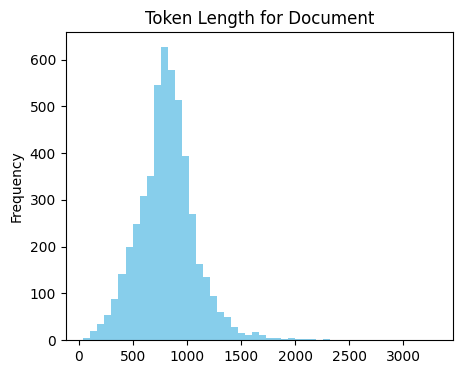

count    5000.000000
mean      816.680400
std       273.701852
min        40.000000
25%       658.000000
50%       808.000000
75%       958.250000
max      3298.000000
Name: token_len, dtype: float64

In [12]:
import matplotlib.pyplot as plt
eda['token_len'] = eda['tokens'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
eda['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document")
plt.grid(False)
plt.show()

eda['token_len'].describe()

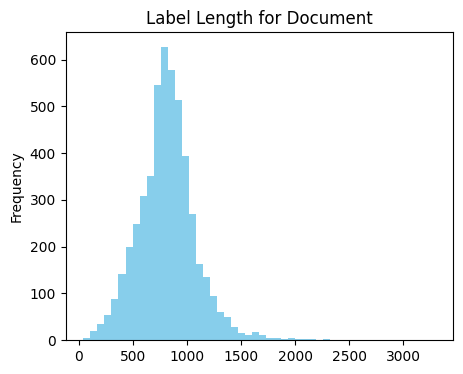

count    5000.000000
mean      816.680400
std       273.701852
min        40.000000
25%       658.000000
50%       808.000000
75%       958.250000
max      3298.000000
Name: label_len, dtype: float64

In [13]:
eda['label_len'] = eda['labels'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
eda['label_len'].plot.hist(bins=50, color='skyblue')
plt.title("Label Length for Document")
plt.grid(False)
plt.show()

eda['label_len'].describe()

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column, 
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)        
    ax.get_legend().remove()
    plt.show()

In [15]:
def plot_non_pii_entity_doc(df):
    df['non_pii_entity_only'] = df['labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))
    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

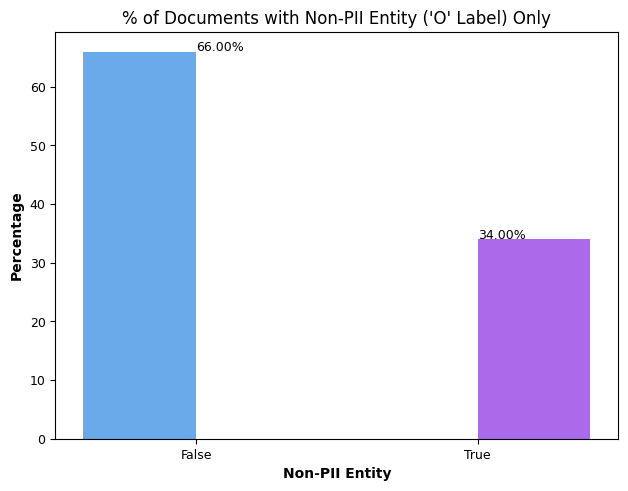

non_pii_entity_only
False    3300
True     1700
Name: count, dtype: int64


In [16]:
plot_non_pii_entity_doc(eda)

In [17]:
from collections import Counter
# label value counts on the train data
labels_chained = chain.from_iterable(eda['labels'])
label_counts = Counter(labels_chained)
label_counts

Counter({'O': 4023635,
         'I-STREET_ADDRESS': 19442,
         'I-NAME_STUDENT': 8555,
         'I-PHONE_NUM': 7989,
         'B-NAME_STUDENT': 7302,
         'B-URL_PERSONAL': 3407,
         'B-EMAIL': 2487,
         'B-ID_NUM': 2454,
         'B-PHONE_NUM': 2394,
         'B-USERNAME': 2380,
         'B-STREET_ADDRESS': 2296,
         'I-ID_NUM': 1060,
         'I-URL_PERSONAL': 1})

In [18]:
def plot_distribution(df):
    # label value counts on the train data
    labels_chained = chain.from_iterable(df['labels']) # bind into one list
    label_counts = Counter(labels_chained)
    
    # get labels and counts, excluding "O"
    labels = [l for l in label_counts.keys() if l != 'O']
    counts = [label_counts[l] for l in labels]

    # sort labels and counts together (descending by counts)
    sorted_data = sorted(zip(labels, counts), key=lambda x: x[1], reverse=False)
    sorted_labels, sorted_counts = zip(*sorted_data)

    # create a horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(sorted_labels, sorted_counts, color='skyblue')

    # add numbers on top of each bar
    for bar, count in zip(bars, sorted_counts):
        xval = bar.get_width()  # Get the width of the bar
        ax.text(xval + 0.1, 
                bar.get_y() + bar.get_height() / 2, 
                str(count), 
                ha='left', 
                va='center',
                fontsize=9)

    plt.xlabel('Count')
    plt.ylabel('Label')
    plt.yticks(rotation=0)
    plt.title('Distribution of Labels (Excluding "O")')

    plt.tight_layout()
    plt.show()
    print("'O' label (%): ", round(label_counts['O']/label_counts.total() * 100, 2))

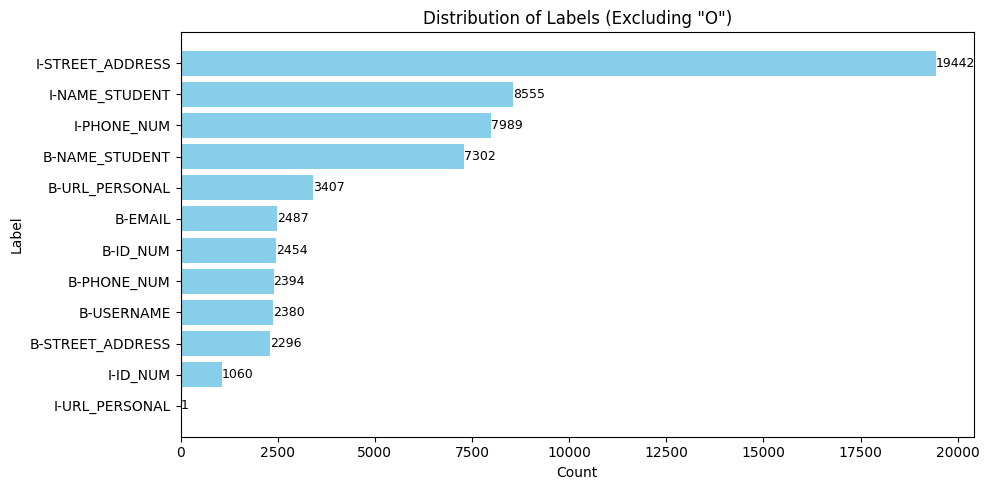

'O' label (%):  98.54


In [19]:
plot_distribution(eda)

training dataset has imbalanced classes 86.12% of the documents with non-PII entity i.e. 'O' label (non-PII) only 99.95% of the labels is non-PII entity ('O' label) label 'B-NAME_STUDENT' and 'I-NAME_STUDENT' for entity 'NAME_STUDENT' are have higher frequency compared to others, except 'O' label

we can do any one of this

collect external data to increase label for entities 'ID_NUM', 'EMAIL', 'URL_PERSONAL', 'PHONE_NUM' and 'STREET_ADDRESS' down sample 'O' label

In [20]:
eda['token_len_512_less'] = eda['token_len'].map(lambda x: x <= 512)
eda['token_len_512_less'].value_counts()

token_len_512_less
False    4409
True      591
Name: count, dtype: int64

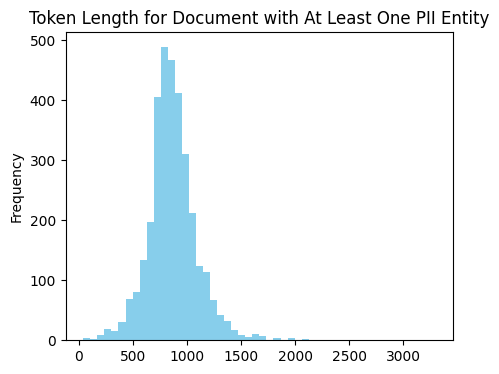

count    3300.000000
mean      867.708788
std       238.739983
min        40.000000
25%       736.000000
50%       848.000000
75%       979.000000
max      3298.000000
Name: token_len, dtype: float64

In [21]:
# check token length for document with at least one PII entity
df_pii = eda[~eda['non_pii_entity_only']]

plt.figure(figsize=(5, 4))
df_pii['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document with At Least One PII Entity")
plt.grid(False)
plt.show()

df_pii['token_len'].describe()

In [22]:
df_pii['token_len_512_less'].value_counts()

token_len_512_less
False    3135
True      165
Name: count, dtype: int64

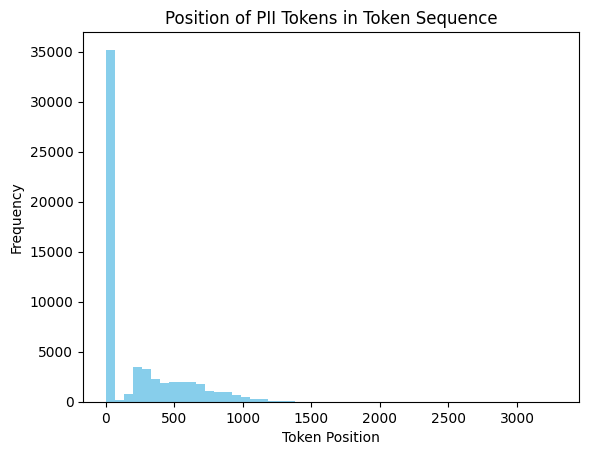

In [23]:
def get_token_index(x):
    return np.array([idx for idx, i in enumerate(x) if i!='O'])

df_pii["labels"].apply(get_token_index).explode().plot.hist(bins=50, color='skyblue')
plt.xlabel("Token Position")
plt.title("Position of PII Tokens in Token Sequence");

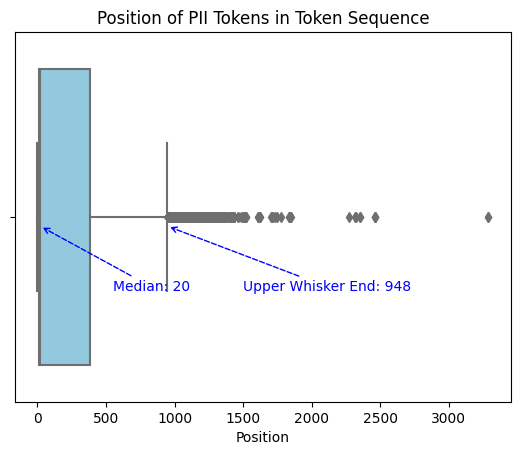

In [24]:
df_pii_token_position = df_pii["labels"].apply(get_token_index).explode().reset_index()
df_pii_token_position.rename(columns={"index": "document", "labels": "position"}, inplace=True)

figplot = sns.boxplot(data=df_pii_token_position, x='position', color='skyblue')
upper_quartile = df_pii_token_position.position.quantile(0.75)
lower_quartile = df_pii_token_position.position.quantile(0.25)
iqr = upper_quartile - lower_quartile
upper_whisker_end = upper_quartile + 1.5 * iqr
figplot.annotate(f'Upper Whisker End: {round(upper_whisker_end)}', 
                     xy=(upper_whisker_end, 0.025), 
                     xytext=(1500, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))

median = df_pii_token_position.position.median()
figplot.annotate(f'Median: {round(median)}', 
                     xy=(median, 0.025), 
                     xytext=(550, 0.2), 
                     fontsize=10, 
                     color='blue', 
                     arrowprops=dict(arrowstyle= '->', color='blue', lw=1.0, ls='--'))
figplot.set_title("Position of PII Tokens in Token Sequence")
figplot.set_xlabel("Position")
plt.show()

In [25]:
print('Total PII entity tokens:', df_pii_token_position['position'].count())

Total PII entity tokens: 59767


In [26]:
# Extract all unique labels from data
all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))

# Create label-to-id and id-to-label mappings
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

# Define target labels
target = [
    'B-NAME_STUDENT', 'I-NAME_STUDENT',
    'B-EMAIL', 
    'B-USERNAME', 
    'B-ID_NUM', 'I-ID_NUM',
    'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-URL_PERSONAL', 
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS'
]

In [27]:
# Initialize the tokenizer for the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(CFG.checkpoint)

# Create a dataset dictionary containing essay data and corresponding labels
ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})

# Tokenize the essays and assign corresponding labels to the tokens
ds = ds.map(dp.tokenize, 
            fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": CFG.max_len}, 
            num_proc=CFG.workers)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

#0:   0%|          | 0/1250 [00:00<?, ?ex/s]

#1:   0%|          | 0/1250 [00:00<?, ?ex/s]

#2:   0%|          | 0/1250 [00:00<?, ?ex/s]

#3:   0%|          | 0/1250 [00:00<?, ?ex/s]

In [28]:
gc.collect()

30394

In [29]:
# class ModelDevelopment:
#     def __init__(self, CFG):
#         self.CFG = CFG
        
#     def compute_metrics(self, p, all_labels):
#         # Unpack predictions and labels
#         predictions, labels = p

#         # Convert predictions to class indices
#         predictions = np.argmax(predictions, axis=2)

#         # Remove ignored index (-100, special tokens)
#         true_predictions = [
#             [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
#             for prediction, label in zip(predictions, labels)
#         ]
#         true_labels = [
#             [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
#             for prediction, label in zip(predictions, labels)
#         ]

#         # Flatten true predictions and true labels
#         flat_true_predictions = [label for sublist in true_predictions for label in sublist]
#         flat_true_labels = [label for sublist in true_labels for label in sublist]

#         # Calculate the F1 score
#         f1 = f1_score(flat_true_labels, flat_true_predictions, average='weighted', labels=all_labels)

#         # Return F1 score as a dictionary
#         return {
#             'f1': f1
#         }

#     def train_and_save_model(self, ds, tokenizer, id2label, label2id, all_labels):
#         model = AutoModelForTokenClassification.from_pretrained(
#             self.CFG.checkpoint,
#             num_labels=len(all_labels),
#             id2label=id2label,
#             label2id=label2id,
#             ignore_mismatched_sizes=True
#         )

#         collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)
        
#         # Define training arguments, derived from the configuration class 
#         args = TrainingArguments(
#             output_dir=self.CFG.output_dir, 
#             fp16=True,
#             learning_rate=self.CFG.learning_rate,
#             num_train_epochs=self.CFG.epochs,
#             per_device_train_batch_size=self.CFG.batch_size,
#             gradient_accumulation_steps=self.CFG.grad_steps,
#             report_to="none",
#             evaluation_strategy="no",
#             do_eval=False,
#             seed=self.CFG.seed,
#             save_total_limit=1,
#             logging_steps=self.CFG.log_steps,
#             lr_scheduler_type='cosine',
#             metric_for_best_model="f1",
#             greater_is_better=True,
#             warmup_ratio=self.CFG.warmup_ratio,
#             weight_decay=self.CFG.weight_decay
#         )

#         trainer = Trainer(
#             model=model, 
#             args=args, 
#             train_dataset=ds,
#             data_collator=collator, 
#             tokenizer=tokenizer,
#             compute_metrics=partial(self.compute_metrics, all_labels=all_labels)
#         )
        
#         # Train and save the model and model tokenizer
#         trainer.train()
#         trainer.save_model(self.CFG.output_name)
#         tokenizer.save_pretrained(self.CFG.output_name)
        
# # Initialize ModelDevelopment class
# md = ModelDevelopment(CFG)

In [32]:
from sklearn.metrics import precision_recall_fscore_support

class ModelDevelopment:
    def __init__(self, CFG):
        self.CFG = CFG
        
    def compute_metrics(self, p, all_labels, beta=1):
        # Unpack predictions and labels
        predictions, labels = p

        # Convert predictions to class indices
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (-100, special tokens)
        true_predictions = [
            [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Flatten true predictions and true labels
        flat_true_predictions = [label for sublist in true_predictions for label in sublist]
        flat_true_labels = [label for sublist in true_labels for label in sublist]

        # Calculate the Fβ score
        precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_true_predictions, average='weighted', labels=all_labels)
        fbeta = (1 + beta*2) * (precision * recall) / ((beta*2 * precision) + recall)

        # Return Fβ score as a dictionary
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fbeta':fbeta
        }
    def evaluate_model(self, model, ds, tokenizer, id2label, label2id, all_labels, beta=1):
        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        trainer = Trainer(
            model=model, 
            data_collator=collator, 
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Evaluate the model on the training dataset
        train_metrics = trainer.evaluate(ds)

        return train_metrics


    def train_and_save_model(self, ds, tokenizer, id2label, label2id, all_labels, beta=1):
        model = AutoModelForTokenClassification.from_pretrained(
            self.CFG.checkpoint,
            num_labels=len(all_labels),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)
        
        # Define training arguments, derived from the configuration class 
        args = TrainingArguments(
            output_dir=self.CFG.output_dir, 
            fp16=True,
            learning_rate=self.CFG.learning_rate,
            num_train_epochs=self.CFG.epochs,
            per_device_train_batch_size=self.CFG.batch_size,
            gradient_accumulation_steps=self.CFG.grad_steps,
            report_to="none",
            evaluation_strategy="no",
            do_eval=False,
            seed=self.CFG.seed,
            save_total_limit=1,
            logging_steps=self.CFG.log_steps,
            lr_scheduler_type='cosine',
            metric_for_best_model="f1",
            greater_is_better=True,
            warmup_ratio=self.CFG.warmup_ratio,
            weight_decay=self.CFG.weight_decay
        )

        trainer = Trainer(
            model=model, 
            args=args, 
            train_dataset=ds,
            data_collator=collator, 
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )
        
        # Train and save the model and model tokenizer
        trainer.train()
        trainer.save_model(self.CFG.output_name)
        tokenizer.save_pretrained(self.CFG.output_name)
        train_metrics = self.evaluate_model(model, ds, tokenizer, id2label, label2id, all_labels, beta=beta)
        print("Training Metrics:")
        print(train_metrics)

md = ModelDevelopment(CFG)

In [33]:
md.train_and_save_model(ds, tokenizer, id2label, label2id, all_labels, beta=1)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,3.568100
20,2.863700
30,0.873600
40,0.260800
50,0.216200
60,0.114400
70,0.085600
80,0.083400
90,0.051000
100,0.034100


Checkpoint destination directory output/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Training Metrics:
{'eval_loss': 0.0009959496092051268, 'eval_precision': 0.9997150215102161, 'eval_recall': 0.9997148365779892, 'eval_f1': 0.999714585186833, 'eval_fbeta': 0.9997148982220573, 'eval_runtime': 480.4538, 'eval_samples_per_second': 10.407, 'eval_steps_per_second': 1.301}
